In [7]:
import numpy as np
import pandas as pd
import scipy

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import matplotlib.pyplot as plt

In [8]:
cancer = load_breast_cancer()
data = pd.DataFrame(data=cancer.data, columns=cancer.feature_names) # data from library

In [9]:
diagnosis = pd.Series(cancer.target, name= "diagnosis")

In [10]:
sel_features = ["mean radius", "mean texture", "mean smoothness"]
dataset = pd.concat([data.loc[:,sel_features], diagnosis], axis=1)

In [31]:
dataset.iloc[2]["diagnosis"]

0.0

In [12]:
def calculate_prior_probability(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior_val = []
    for i in classes:
        prior_val.append(len(df[df[Y]==i])/len(df))
    print(prior_val)
    return prior_val

In [13]:
def cal_likelihood_gau(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    pro_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return pro_x_given_y

In [14]:
def naive_bayes_gaussian(df, X, Y):
    # get all of the features in your dataset 
    features = list(df.columns)[:-1]

    # calculate prior probability using  calculate_prior_probability function
    prior = calculate_prior_probability(df, Y)

    Y_pred = []
    # apply loop over the sample and create likelihood using cal_likelihood_gau function.
    for x in X:
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *=cal_likelihood_gau(df, features[i], x[i], Y, labels[j])

        # calculate all of the possible posterior value 
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]
        
       # Find the maximum posterior value which is the expected output.
        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [34]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[0.378021978021978, 0.621978021978022]
[[36  4]
 [ 0 74]]
0.9736842105263158


In [15]:
class NaiveBayesClassifier:
    """
    Class to represent a Naive Bayes Classifier.
    """

    def __init__(self, dataset: pd.DataFrame, test_size: float = 0.2) -> None:
        """
        Initialization of the Naive Bayes Classifier instance.
        Input validation and train-test split.

        Parameters
        ----------
        dataset : pd.DataFrame

        test_size: float
            default = 0.2
            must be between 0.0 and 1.0
        """
        if not isinstance(dataset, pd.DataFrame):
            raise ValueError("The dataset must be a pandas DataFrame.")
        if not isinstance(test_size, float):
            raise ValueError("The test_size must be a floating number")
        if test_size < 0.0:
            raise ValueError("The test_size must be greater than 0.")
        if test_size > 1.0:
            raise ValueError("The test_size must be less than 1.")
        train_data, test_data = train_test_split(
            dataset, test_size=test_size, random_state=41
        )
        self.train_features: pd.DataFrame = train_data.iloc[:, :-1]
        self.train_labels: pd.Series = train_data.iloc[:, -1]
        self.test_features: pd.DataFrame = test_data.iloc[:, :-1]
        self.test_labels: pd.Series = test_data.iloc[:, -1]

    def plot_features_histograms(self) -> None:
        def draw_histograms(df, variables, n_rows: int = 1, n_cols: int = 1):
            fig = plt.figure()
            for i, var_name in enumerate(variables):
                ax = fig.add_subplot(n_rows, n_cols, i + 1)
                df[var_name].hist(bins=10, ax=ax)
                ax.set_title("Distribution of " + var_name)
            fig.tight_layout()  # Improves appearance a bit.
            plt.show()

        draw_histograms(self.train_features, self.features, len(self.features), 1)

    @property
    def n_train_samples(self) -> int:
        return len(self.train_features.index)

    @property
    def n_test_samples(self) -> int:
        return len(self.test_features.index)

    @property
    def features(self) -> pd.Index:
        return self.train_features.columns

    @property
    def labels(self) -> np.ndarray:
        return sorted(self.train_labels.unique())

    @property
    def prior(self) -> pd.DataFrame:
        """
        Method to calculate the prior probability associated to each label.
        It takes into consideration only the TRAIN labels.

        Returns
        -------
        priors: pd.DataFrame
            A dataframe where each label is mapped to its prior.
        """
        _prior = pd.DataFrame(columns=self.labels)
        for label in self.labels:
            _prior[label] = pd.Series(
                len(self.train_labels[self.train_labels == label])
                / len(self.train_labels)
            )
        return _prior

    def likelihood(self) -> pd.DataFrame:
        """
        Method to calculate the likelihood.

        Returns
        -------
        A pandas DataFrame with a probability for each label and each test observation.
        """

        # def gaussian_pdf(x: float, mu: float, sigma_squared: float) -> pd.Series:
        #     sigma = np.sqrt(sigma_squared)
        #     numerator = np.exp(-(((x - mu) / sigma) ** 2) * 0.5)
        #     denominator = np.sqrt(2 * np.pi * sigma_squared)
        #     pdf = numerator / denominator
        #     return pdf

        _likelihood = pd.DataFrame(
            data=np.ones(shape=(len(self.test_features.index), len(self.labels))),
            columns=self.labels,
        )
        _mean = pd.DataFrame(columns=self.labels)
        _variance = pd.DataFrame(columns=self.labels)
        for label in self.labels:
            _features_per_label = self.train_features[label == self.train_labels]
            _mean[label] = _features_per_label.mean()
            _variance[label] = _features_per_label.var()
            for feature in self.features:
                # _likelihood[label] *= gaussian_pdf(
                #     self.test_features[feature],
                #     _mean[label][feature],
                #     _variance[label][feature],
                # )
                _likelihood[label] *= scipy.stats.norm(
                    _mean[label][feature], _variance[label][feature]
                ).pdf(self.test_features[feature])
        assert not _likelihood.empty
        return _likelihood

    @property
    def normalization(self) -> pd.Series:
        _norm = 0
        for label in self.labels:
            _norm += self.likelihood()[label] * self.prior[label].values
        return _norm

    @property
    def posterior(self) -> pd.DataFrame:
        """
        Method to calculate the posterior probability associated to each label.

        Returns
        -------
        posteriors: pd.DataFrame
            A series where each label is mapped to its posterior.
        """
        _posterior = pd.DataFrame(columns=self.labels)
        for label in self.labels:
            _posterior[label] = (
                self.prior[label].values * self.likelihood()[label] / self.normalization
            )
        return _posterior

    def prediction(self) -> pd.Series:
        pred = self.posterior.apply(np.argmax, axis=1)
        return pred

    def print_accuracy(self) -> None:
        my_accuracy_score = accuracy_score(
            self.test_labels, self.prediction(), normalize=True
        )
        my_confusion_matrix = confusion_matrix(self.test_labels, self.prediction())
        my_f1_score = f1_score(self.test_labels, self.prediction())

        print("{0:<15} {1:>15}".format("my accuracy", my_accuracy_score))
        print("{0:<15} {1:>15}".format("my f1", my_f1_score))
        print("my confusion matrix: \n", my_confusion_matrix)

In [16]:
bayes = NaiveBayesClassifier(dataset=dataset)

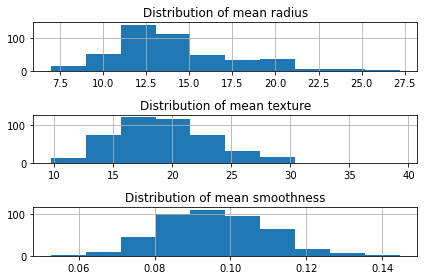

In [17]:
bayes.plot_features_histograms()

In [18]:
bayes.prior

,0,1
0,0.378022,0.621978


Il problema è che la likelihood è molto vicina a 0, questo avviene soprattutto se prendiamo in considerazione anche la terza colonna

In [19]:
bayes.likelihood()

,0,1
0,0.000000e+00,0.000000e+00
1,0.000000e+00,1.086443e-75
2,0.000000e+00,0.000000e+00
3,2.490445e-160,0.000000e+00
4,0.000000e+00,0.000000e+00
...,...,...
109,2.121806e-02,0.000000e+00
110,0.000000e+00,0.000000e+00
111,5.798454e-59,0.000000e+00
112,0.000000e+00,0.000000e+00


In [21]:
bayes.normalization

0       0.000000e+00
1       6.757437e-76
2       0.000000e+00
3      9.414431e-161
4       0.000000e+00
           ...      
109     8.020892e-03
110     0.000000e+00
111     2.191943e-59
112     0.000000e+00
113    7.499576e-156
Name: 0, Length: 114, dtype: float64

Dato che sia la likelihood che i fattori di normalizzazione tendono a zero la posterior è piena di 0 e NaN

In [20]:
bayes.posterior

,0,1
0,NaN,NaN
1,0.0,1.0
2,NaN,NaN
3,1.0,0.0
4,NaN,NaN
...,...,...
109,1.0,0.0
110,NaN,NaN
111,1.0,0.0
112,NaN,NaN


Se elimino la terza colonna delle caratteristiche 
(che avendo valori molto piccoli ha media prossima a zero)
allora non ci sono problemi!

In [22]:
sel_features = ["mean radius", "mean texture"]
dataset = pd.concat([data.loc[:,sel_features], diagnosis], axis=1)
bayes = NaiveBayesClassifier(dataset=dataset)
bayes.likelihood()

,0,1
0,0.001019,0.002870
1,0.001010,0.002069
2,0.001024,0.002141
3,0.001019,0.002862
4,0.000984,0.002880
...,...,...
109,0.001003,0.002857
110,0.000692,0.001869
111,0.001070,0.002654
112,0.000911,0.002732


In [23]:
bayes.normalization

0      0.002171
1      0.001669
2      0.001719
3      0.002165
4      0.002163
         ...   
109    0.002156
110    0.001424
111    0.002055
112    0.002044
113    0.001949
Name: 0, Length: 114, dtype: float64

In [24]:
bayes.posterior

,0,1
0,0.177452,0.822548
1,0.228847,0.771153
2,0.225221,0.774779
3,0.177817,0.822183
4,0.172017,0.827983
...,...,...
109,0.175817,0.824183
110,0.183749,0.816251
111,0.196729,0.803271
112,0.168513,0.831487


In [25]:
bayes.prediction()

0      1
1      1
2      1
3      1
4      1
      ..
109    1
110    1
111    1
112    1
113    1
Length: 114, dtype: int64

In [26]:
bayes.print_accuracy()

my accuracy     0.8596491228070176
my f1           0.9024390243902439
my confusion matrix: 
 [[24 16]
 [ 0 74]]
